Authors: Baptiste Pierrat (pierrat@emse.fr), Jérôme Molimard (molimard@emse.fr)

# About this notebook...

This is a Jupyter notebook. Jupyter notebooks are a great way to combine teaching of theory and numerical implementation in Python side-by-side and in an interactive manner. They can also be used to export PDF handouts.

Students are expected to go through this notebook and interact with it if they like. A short introduction to interacting with Jupyter notebooks in Google Colab is available here: https://colab.research.google.com/notebooks/welcome.ipynb

The recommended steps to interact with this notebook are the following:

* Save a copy on your Drive (File -> Save a copy in Drive).
* You can execute a cell by hitting Ctrl + Enter or clicking on the Run icon in the top left of each cell
* You can run all the cells at once by going to Runtime -> Run all
* You are expected to fill the blanks in this notebook, and answer to questions (identified by this symbol: :question:). You can also add cells if you want to experiment further. At the end of the session, export the notebook as a PDF and submit it. Please add your name to the list of authors above.

First, let's start by importing the necessary libraries.

In [1]:
from importlib import reload
import utils
utils = reload(utils) # Reload the module in case it has changed
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import scienceplots

# Nice plot style
plt.style.use(['science', 'notebook', 'grid'])

# Appropriately sized plots
plt.rcParams['figure.dpi'] = 80

# Continuing from the lab session

Remember that last week you performed three tensile tests on three different samples:
- A rubber band
- An strip of aortic tissue
- A rubber band with a hole in the middle

For each sample, you took measurements of:
- The width and thickness of the sample
- The initial clamp-to-clamp length of the sample

You also obtained data from the tensile machine:
- The force applied to the sample
- The displacement of the machine

You also took pictures of the samples during the test, and performed Digital Image Correlation (DIC). This allowed you to obtain:
- The displacement field of the sample
- The strain field of the sample

Take a brief moment to open the 'Test Data' folder and look at the available data.

We will use the data from these tests to identify the mechanical properties of the materials.

# The uniaxial tensile test

As we have seen during the experimental session, the uniaxial tensile test is based on the assumption that 
- the stresses are uniformly distributed over the specimen cross-section and purely uniaxial
- the strains are uniformly distributed over the specimen gauge length (where measurements are taken)

As a consequence, **a single value of axial stress and strain can be defined at each point in time during the test.**

See in the video below how the axial strain is almost uniform in the sample:

<video controls src="Test Data/Rubber band/DIC Data/Videos/exx.mp4" width="50%" />

# Theory: A Brief Review of Different Measures of Stress and Strain

For soft materials such as rubber and biological tissues, the deformation is often large and nonlinear. You may remember that stress is usually defined as the force applied to a material divided by the cross-sectional area of the material. However, in the case of large deformations, the cross-sectional area changes during deformation, and the definition of stress needs to be adapted. The same applies to strain measurements.

Understanding the different measures of stress and strain is crucial. Here is a brief review of the different measures of stress and strain for uniaxial loading conditions.

## Stress measures

### Nominal Stress (Engineering Stress)
Nominal stress, also known as engineering stress, is defined as the force applied to a material divided by the original cross-sectional area of the material. It is given by the formula:
$ \sigma_n = \frac{F}{A_0} $
where:
- $ \sigma_n $ is the nominal stress,
- $ F $ is the applied force,
- $ A_0 $ is the original cross-sectional area.

### Cauchy Stress (True Stress)
Cauchy stress, or true stress, takes into account the actual cross-sectional area of the material at any given point during deformation. It is defined as:
$ \sigma_t = \frac{F}{A} $
where:
- $ \sigma_t $ is the true stress,
- $ F $ is the applied force,
- $ A $ is the current cross-sectional area.

*Note: it is usually quite challenging to measure the actual cross-sectional area of the material during deformation. Sometimes it can be estimated by making assumptions about the deformation (ex: incompressibility of the material), or by using techniques such as Digital Image Correlation (DIC).*

The phenomenon is illustrated in the figure below:

<img src="Images/nominal_true_stress.png" width=20% />

## Strain measures

### Nominal Strain (Engineering Strain)
Nominal strain, also known as engineering strain, is the ratio of the change in length to the original length of the material. It is given by:
$ \varepsilon_n = \frac{\Delta L}{L_0} $
where:
- $ \varepsilon_n $ is the nominal strain,
- $ \Delta L $ is the change in length,
- $ L_0 $ is the original length.

### True Strain
True strain accounts for the continuous change in length during deformation. It is defined as the natural logarithm of the ratio of the instantaneous length to the original length:
$ \varepsilon_t = \ln \left( \frac{L}{L_0} \right) $
where:
- $ \varepsilon_t $ is the true strain,
- $ L $ is the instantaneous length,
- $ L_0 $ is the original length.

### Green-Lagrange Strain
Green-Lagrange strain is a measure used in finite deformation theory. It is defined as:
$ E = \frac{1}{2} \left( \frac{L^2 - L_0^2}{L_0^2} \right) $
where:
- $ E $ is the Green-Lagrange strain,
- $ L $ is the instantaneous length,
- $ L_0 $ is the original length.

*Note: the strain values obtained from DIC in VIC3D are Green-Lagrange strains.*


# Constitutive Models

A constitutive model is a mathematical representation of the relationship between stress and strain in a material. Different constitutive models can be used to describe the behavior of materials under different loading conditions.

Mathematically, a constitutive model can be represented as:
$ \sigma = f(\varepsilon) $
where:
- $ \sigma $ is the stress tensor,
- $ \varepsilon $ is the strain tensor,
- $ f $ is the constitutive function.

*Note: for a visco-elastic material, the constitutive function may depend on time as well:*
$ \sigma = f(\varepsilon, t) $

In this notebook, we will focus on two constitutive models:
- A linear elastic model
- A hyperelastic model


# Validity of the Constitutive Models

The validity of a constitutive model depends on the material behavior and the application. Here are some general guidelines:
- Using a model outside the range (stress, strain) in which it has been characterized is an extrapolation that may lead to inaccurate results.
- Having a clear application of the model in mind helps in making the appropriate choice.

**Here we will assume that we are currently developing an aortic graft aiming at replacing a damaged aorta. The rubber band is to be used as a graft material.**

<img src="Images/aortic_graft.jpg" width=30% />

> **:question: What are the main mechanical requirements for the aortic graft?**

# A simple linear elastic material model

A linear elastic material is characterized by a linear relationship between stress and strain. The constitutive equation for a linear elastic material is given by:
$ \sigma = E \varepsilon $
where:
- $ \sigma $ is the stress,
- $ E $ is the elastic modulus, sometimes referred to as Young's modulus,
- $ \varepsilon $ is the strain.

<img src="Images/modulus.jpg" width=30% />

The elastic modulus is a measure of the stiffness of the material.

This model is valid for
- small deformations
- linear stress-strain response
- isotropic material
- purely elastic behavior
- non-time-dependent behavior (i.e., no viscoelasticity)

> **Question: Comment on the validity of the linear elastic model for the rubber band and the aortic tissue. Here we will use the nominal stress and strain to identify the elastic modulus of the material. Why?**

In order to extract data from the CSV files obtained from the tensile tests, we will use the following function (already implemented):

```python

def utils.extract_data_from_tensile_test(file, segment_number='all', tare=False):
    """
    Extracts data from a tensile test CSV file.

    Parameters:
    file (str): Path to the CSV file containing tensile test data.
    segment_number (str or int, optional): The segment number to extract. Defaults to 'all'.
        If 'all', data from all segments will be extracted.
    tare (bool, optional): If True, the data will be tared (i.e., the initial values will be subtracted). Defaults to False.

    Returns:
    tuple: A tuple containing three numpy arrays:
        - displacement (numpy.ndarray): Displacement data in mm.
        - force (numpy.ndarray): Force data in N.
        - time (numpy.ndarray): Time data in seconds.
    """
```

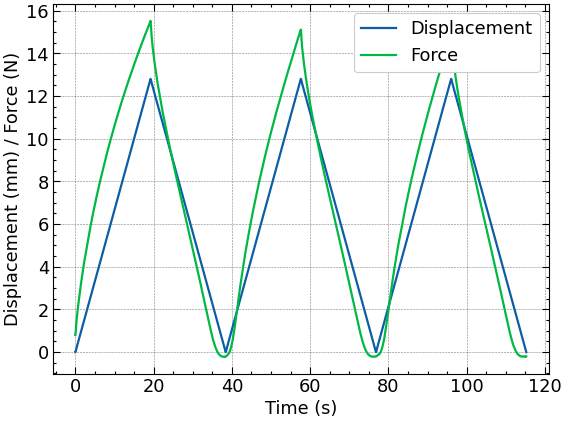

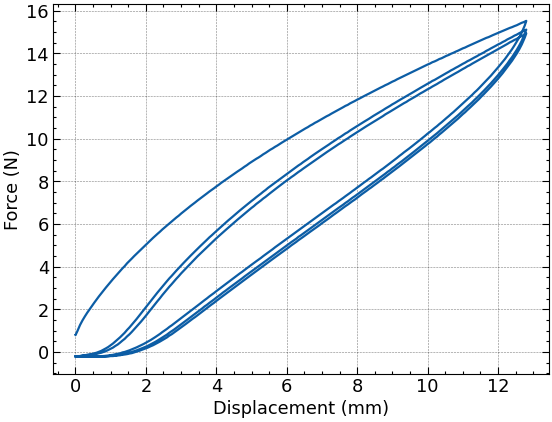

In [2]:
# Use the extract_data_from_tensile_test function to extract data from the tensile test
disp_rubber, force_rubber, time_rubber = utils.extract_data_from_tensile_test("Test Data/Rubber band/Tensile Data/data.csv")

# Plot vs time
plt.figure()
plt.plot(time_rubber, disp_rubber, label="Displacement")
plt.plot(time_rubber, force_rubber, label="Force")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (mm) / Force (N)")
plt.legend()
plt.show()


# Plot force vs diplacement
plt.figure()
plt.plot(disp_rubber, force_rubber)
plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")
plt.show()



> **:question: Calculate the nominal stress and strain. Plot the nominal stress-strain curve.**

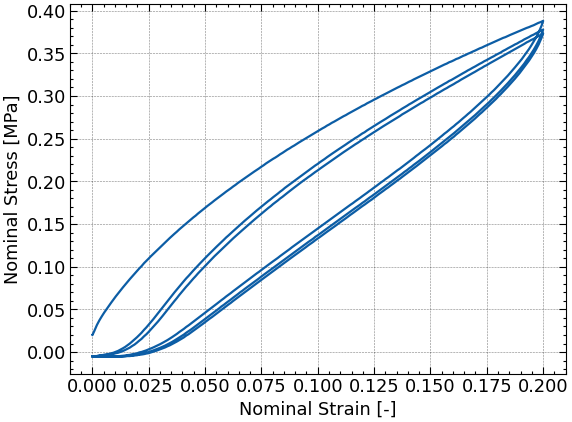

In [3]:
width = 40
thickness = 1
area = width * thickness
nominal_stress_rubber = force_rubber / area
clamp_to_clamp_distance = 64
nominal_strain_rubber = disp_rubber / clamp_to_clamp_distance

# Plot stress vs strain
plt.figure()
plt.plot(nominal_strain_rubber, nominal_stress_rubber)
plt.xlabel("Nominal Strain [-]")
plt.ylabel("Nominal Stress [MPa]")
plt.show()


> **Question: Use the printed curve to identify the elastic modulus of the material. There are different choices/assumptions to make, explain them briefly. Remember the target application: which mechanical loading conditions are expected for the aortic graft?**

> **Do the same for the aortic tissue.**

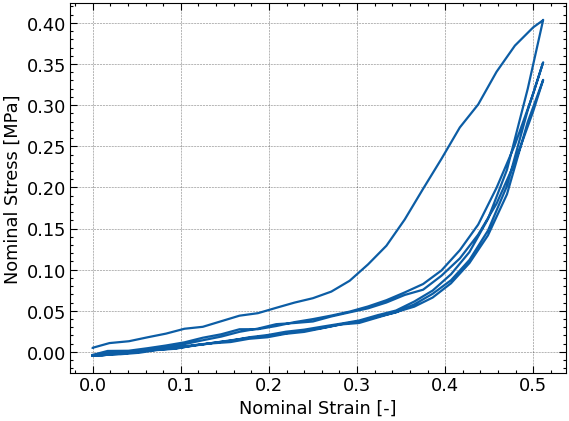

In [4]:
# Same for the aorta

# Use the extract_data_from_tensile_test function to extract data from the tensile test
disp_aorta, force_aorta, time_aorta = utils.extract_data_from_tensile_test("Test Data/Aorta/Tensile Data/data.csv")

width = 15
thickness = 1.9
area = width * thickness

nominal_stress_aorta = force_aorta / area

clamp_to_clamp_distance = 48

nominal_strain_aorta = disp_aorta / clamp_to_clamp_distance

# Plot stress vs strain
plt.figure()
plt.plot(nominal_strain_aorta, nominal_stress_aorta)
plt.xlabel("Nominal Strain [-]")
plt.ylabel("Nominal Stress [MPa]")
plt.show()


> **:question: Comment on the validity of the linear elastic model for the rubber band and the aortic tissue. Does the rubber material make a good candidate for the aortic graft?**

# A hyperelastic material model

## Theory: hyperelasticity

Hyperelasticity is a constitutive model that describes materials that may exhibit large deformations and nonlinear stress-strain behavior. Hyperelastic materials are often used to model rubber-like materials and biological tissues.

The concept of hyperelasticity is based on the notion of a strain energy function, which is a mathematical function that describes the **energy stored in a material as a function of the deformation**.

A common strain energy function used to describe hyperelastic materials is the **Neo-Hookean model**. Assuming incompressibility of the material, the Neo-Hookean model is defined by the following strain energy function:

$ W = C_{1} (I_1 - 3)$

where:
- $ W $ is the strain energy density,
- $ C_1 $ is a material constant,
- $ I_1 $ is the first invariant of the Cauchy-Green deformation tensor, defined as $ I_1 = \lambda_1^2 + \lambda_2^2 + \lambda_3^2 $, where $ \lambda_i $ are the principal stretches.

The stretch ratio $ \lambda $ is defined as the ratio of the deformed length to the original length: $ \lambda = \frac{L}{L_0} $.

The Cauchy stress can be obtained by differentiating the strain energy function with respect to the deformation gradient. Details are given on the Wikipedia page: https://en.wikipedia.org/wiki/Neo-Hookean_solid. For a uniaxial tensile test, the axial nominal stress is:

$ \sigma_n = 2 C_1 (\lambda_{1}^2 - \lambda_{3}^2) \frac{1}{\lambda_1} $


> **:question: For a uniaxial tensile test, what are the principal stretches $ \lambda_1, \lambda_2, \lambda_3 $ as a function of the displacement $ \Delta L $ and the initial length $ L_0 $? Make use of the assumption of incompressibility.**

> **:question: Plot the stress-strain curve for the Neo-Hookean model with a hyperelastic material constant $ C_1 = 1 $ together with the experimental stress-strain curve for the rubber band.**

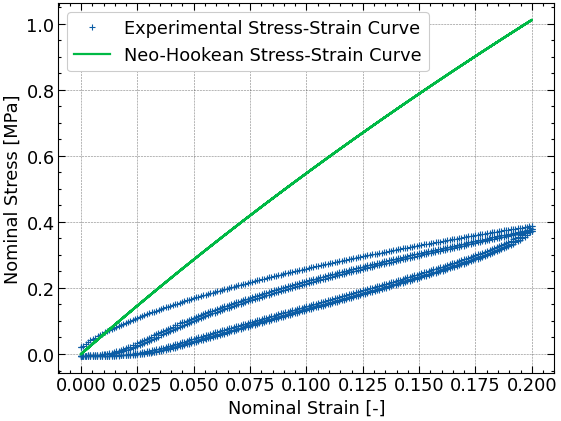

In [5]:

# Calculate the principal stretches
lambda_1 = nominal_strain_rubber + 1
lambda_3 = 1 / np.sqrt(lambda_1)  # Assuming incompressibility

# Calculate the Neo-Hookean stress
C1 = 1
neo_hookean_stress = 2 * C1 * (lambda_1**2 - lambda_3**2) / lambda_1

# Plot the experimental and theoretical stress-strain curves
plt.figure()

# Experimental stress-strain curve
plt.plot(nominal_strain_rubber, nominal_stress_rubber, '+', label="Experimental Stress-Strain Curve")

# Neo-Hookean stress-strain curve
plt.plot(nominal_strain_rubber, neo_hookean_stress, label="Neo-Hookean Stress-Strain Curve")

plt.xlabel("Nominal Strain [-]")
plt.ylabel("Nominal Stress [MPa]")
plt.legend()
plt.show()

> **:question: Now we want to identify the hyperelastic material constant $ C_1 $ from the experimental data. Naively, how would you proceed?**

## Non-linear least squares fitting

Non-linear least squares fitting is a method used to fit a model to experimental data. The idea is to minimize the sum of the squares of the differences between the model predictions and the experimental data.

The SciPy library provides a function called `least_squares` that can be used to perform non-linear least squares fitting. Given a model function $f$ and experimental data $y$, the `least_squares` function finds the parameters that minimize the residual function $r$ defined as the difference between the model predictions and the experimental data: $r(\text{params}) = f(\text{params}) - y$.
The `least_squares` function takes as input:
- a residual function `r(params) = f(params) - exp_data`,
- an initial guess for the parameters `params0`.

An example of how to use the `least_squares` function is given below:


In [6]:
from scipy.optimize import least_squares

xdata = np.array([1, 2, 3, 4, 5])
ydata = np.array([1, 2, 3, 4, 5])

def model(params, x):
    return np.sin(params[0] * x + params[1])

def residual(params):
    return model(params, xdata) - ydata

params0 = [1, 0]

result = least_squares(residual, params0)

print(result.x)

[0.03561321 1.41816247]


> **:question: Write the residual function for the Neo-Hookean model with the hyperelastic material constant $ C_1 $ as a parameter. Use the nominal stress-strain data for the rubber band as the experimental data. Then, use the `least_squares` function to identify the hyperelastic material constant $ C_1 $. Plot the experimental data and the fitted curve.**

*Note: you can use the `segment_number` keyword option in the function `extract_data_from_tensile_test` to extract the data only for a given cycle.*

Fitted C1: 0.40 MPa


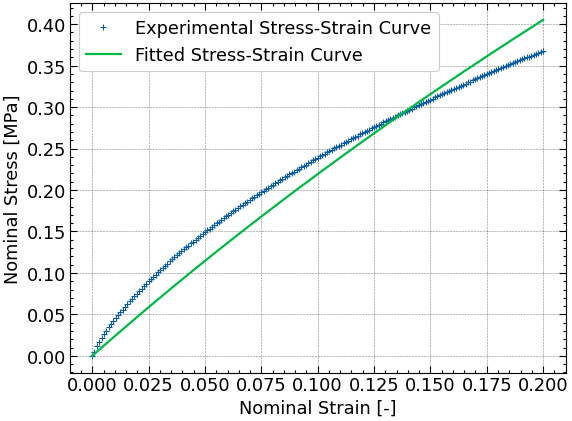

In [7]:
from scipy.optimize import least_squares

disp_rubber, force_rubber, time_rubber = utils.extract_data_from_tensile_test("Test Data/Rubber band/Tensile Data/data.csv", segment_number=1, tare=True)
nominal_strain_rubber = disp_rubber / 64
nominal_stress_rubber = force_rubber / (40 * 1)

def neo_hookean_stress(C1, nominal_strain):
    lambda_1 = nominal_strain + 1
    lambda_3 = 1 / np.sqrt(lambda_1)  # Assuming incompressibility
    return 2 * C1 * (lambda_1**2 - lambda_3**2) / lambda_1

# Residual function for the Neo-Hookean model
def residuals(params):
    C1 = params[0]
    model_stress = neo_hookean_stress(C1, nominal_strain_rubber)
    return model_stress - nominal_stress_rubber

# Initial guess for C1
initial_guess = [1]

# Perform the least squares fitting
result = least_squares(residuals, initial_guess)

# Extract the fitted C1 value
fitted_C1 = result.x[0]
print(f"Fitted C1: {fitted_C1:.2f} MPa")

# Plot the experimental and fitted stress-strain curves
plt.figure()

# Experimental stress-strain curve
plt.plot(nominal_strain_rubber, nominal_stress_rubber, '+', label="Experimental Stress-Strain Curve")

# Fitted stress-strain curve
model_stress_rubber = neo_hookean_stress(fitted_C1, nominal_strain_rubber)
plt.plot(nominal_strain_rubber, model_stress_rubber, label="Fitted Stress-Strain Curve")

plt.xlabel("Nominal Strain [-]")
plt.ylabel("Nominal Stress [MPa]")
plt.legend()
plt.show()

> **:question: Now do the same for the aortic tissue.**

Fitted C1 for aortic tissue: 0.08 MPa


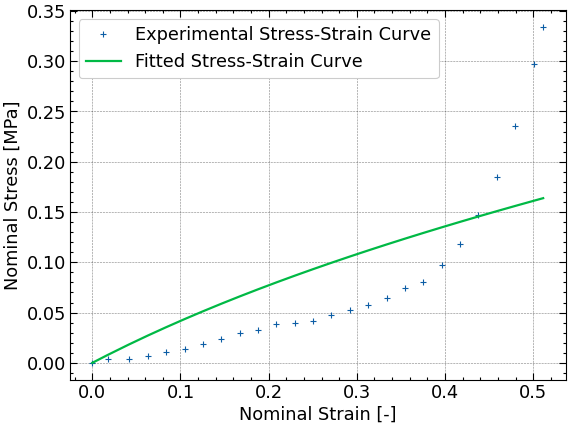

In [8]:
disp_aorta, force_aorta, time_aorta = utils.extract_data_from_tensile_test("Test Data/Aorta/Tensile Data/data.csv", segment_number=5, tare=True)

# Calculate nominal strain and stress for the aortic tissue
nominal_strain_aorta = disp_aorta / 48
nominal_stress_aorta = force_aorta / (15 * 1.9)

# Residual function for the Neo-Hookean model
def residuals_aorta(params):
    C1 = params[0]
    model_stress = neo_hookean_stress(C1, nominal_strain_aorta)
    return model_stress - nominal_stress_aorta

# Initial guess for C1
initial_guess_aorta = [1]

# Perform the least squares fitting
result_aorta = least_squares(residuals_aorta, initial_guess_aorta)

# Extract the fitted C1 value
fitted_C1_aorta = result_aorta.x[0]
print(f"Fitted C1 for aortic tissue: {fitted_C1_aorta:.2f} MPa")

# Plot the experimental and fitted stress-strain curves for the aortic tissue
plt.figure()

# Experimental stress-strain curve
plt.plot(nominal_strain_aorta, nominal_stress_aorta, '+', label="Experimental Stress-Strain Curve")

# Fitted stress-strain curve
model_stress_aorta = neo_hookean_stress(fitted_C1_aorta, nominal_strain_aorta)
plt.plot(nominal_strain_aorta, model_stress_aorta, label="Fitted Stress-Strain Curve")

plt.xlabel("Nominal Strain [-]")
plt.ylabel("Nominal Stress [MPa]")
plt.legend()
plt.show()

> **:question: Comment on the validity of the Neo-Hookean model for the rubber band and the aortic tissue.**

## A hyperelastic model for biological tissues: the Fung model

The Fung model is a hyperelastic model that is commonly used to describe the mechanical behavior of biological tissues. The Fung model is defined by the following strain energy function:

$ W = c (e^{k(I_1 - 3)} - 1) $

where:
- $ W $ is the strain energy density,
- $ c $ and $ k $ are material constants

The nominal stress for the Fung model is given by:

$ \sigma_n = 2\ c\ k \exp\left(\frac{k (\lambda_1 - 1)^2 (\lambda_1 + 2)}{\lambda_1}\right) (\lambda_1^3 - 1) \frac{1}{\lambda_1^2} $

In Python directly:
```python
(2 * c * k * np.exp((k * (lambda_1 - 1)**2 * (lambda_1 + 2)) / lambda_1) * (lambda_1**3 - 1)) / lambda_1**2
```

> **:question: Identify the material constants $ c $ and $ k $ for the Fung model from the experimental data for the aortic tissue.**



Fitted c: 0.0034 MPa, Fitted k: 3.97


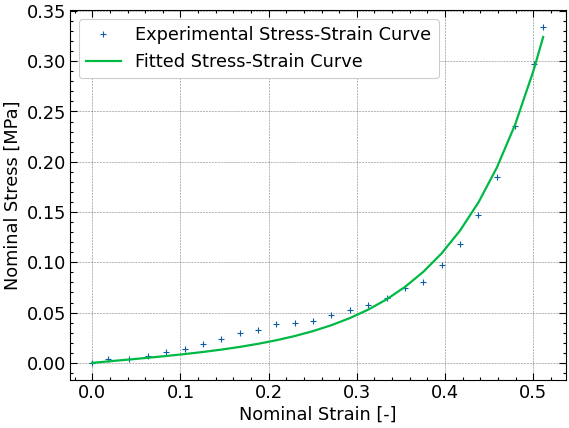

In [9]:

def fung_stress(c, k, nominal_strain):
    lambda_1 = nominal_strain + 1
    return (2 * c * k * np.exp((k * (lambda_1 - 1)**2 * (lambda_1 + 2)) / lambda_1) * (lambda_1**3 - 1)) / lambda_1**2

# Residual function for the Fung model
def residuals_fung(params):
    c, k = params
    model_stress = fung_stress(c, k, nominal_strain_aorta)
    return model_stress - nominal_stress_aorta

# Initial guess for c and k
initial_guess_fung = [1, 1]

# Perform the least squares fitting
result_fung = least_squares(residuals_fung, initial_guess_fung)

# Extract the fitted c and k values
fitted_c, fitted_k = result_fung.x
print(f"Fitted c: {fitted_c:.4f} MPa, Fitted k: {fitted_k:.2f}")

# Calculate the Fung model stress using the fitted parameters
model_stress_aorta = fung_stress(fitted_c, fitted_k, nominal_strain_aorta)

# Plot the experimental and fitted stress-strain curves for the aortic tissue
plt.figure()

# Experimental stress-strain curve
plt.plot(nominal_strain_aorta, nominal_stress_aorta, '+', label="Experimental Stress-Strain Curve")

# Fitted stress-strain curve
plt.plot(nominal_strain_aorta, model_stress_aorta, label="Fitted Stress-Strain Curve")

plt.xlabel("Nominal Strain [-]")
plt.ylabel("Nominal Stress [MPa]")
plt.legend()
plt.show()


# Inverse Identification using Finite Element Analysis

We now aim at identifying the material properties of the rubber band with the hole. We will consider that this structure is made of two materials: the rubber band and the ring around the hole.

> **:question: Which assumptions that were previously to obtain stress and strain made are no longer valid for the rubber band with the hole?**

Here we cannot build a simple analytical model function that describes the stress-strain relationship. Instead, we will use a Finite Element Analysis (FEA) to simulate the tensile test and predict the force vs. displacement curve. We will then compare the FEA results with the experimental data to identify the material properties. This is known as inverse identification.

> **:question: Draw a simple diagram of the inverse identification process using FEA.**

## Description of the FE model
- The geometry is a 2D rectangle with a hole in the middle.
- Around the hole, there is a ring of a different material.
- The materials are assumed to be isotropic and hyperelastic.
- The Neo-Hookean model is used to describe the material behavior.
- The boundary conditions are displacement-controlled: the left side is fixed ($u_x = u_y = 0$), and the right side is displaced ($u_x = \Delta L$, $u_y = 0$).
- The implemented FEA code is provided in the file `utils.py`. It is based on FenicsX, a finite element library in Python.

<img src="Images/FEA.png" width=50% />

You can use the following code to run the FEA simulation and plot the results:

```python
    model = utils.FEModel(width, height, thickness, hole_diameter, ring_diameter, mesh_size=None)
    """
    Initializes a finite element simulation of a plate with a hole in the center.
    
    Parameters:
    width (float): Width of the plate.
    height (float): Height of the plate.
    thickness (float): Thickness of the plate.
    hole_diameter (float): Diameter of the hole.
    ring_diameter (float): Diameter of the ring.
    mesh_size (float, optional): Mesh size. Defaults to width / 10.

    """

    model.set_material_parameters(self, C1_rubber, C1_ring):
    """
    Sets the material parameters for the rubber and the ring.

    Parameters:
    C1_rubber (float): Material parameter for the rubber.
    C1_ring (float): Material parameter for the ring.
    """
    
    force_values = model.solve(disp_values, show_progress=True, update_plot=True):
    """
    Solves the finite element problem for a series of displacement values.

    Parameters:
    disp_values (numpy.ndarray): Displacement values to apply.

    Returns:
    numpy.ndarray: Model forces.
    """
```

An example is given below.

In [10]:
# Get data from the hole tensile test
disp_hole, force_hole, time_hole = utils.extract_data_from_tensile_test("Test Data/Hole/Tensile Data/data.csv", segment_number=1, tare=True)

# Resample the data to have 21 points in order to speed up the FE simulation
disp_hole_resampled = np.linspace(0, np.max(disp_hole), 21)
force_hole_resampled = np.interp(disp_hole_resampled, disp_hole, force_hole)

# Initialize the FE model
model = utils.FEModel(width=41, height=75, thickness=1, hole_diameter=7.2, ring_diameter=25., SEF="Neo-Hookean")
C1_rubber = 0.4
C1_ring = 1.
model.set_material_parameters_NH(C1_rubber, C1_ring)

viewer = model.init_plot()
display(viewer)


Widget(value='<iframe src="http://localhost:45763/index.html?ui=P_0x73f5a4169a00_0&reconnect=auto" class="pyvi…

In [11]:

# Run the FE simulation for the hole
model_force_hole = model.solve(disp_hole_resampled)

Increment 0: Displacement: 0.00 mm, Force: -0.00 N
Increment 1: Displacement: 3.75 mm, Force: 5.37 N
Increment 2: Displacement: 7.50 mm, Force: 10.25 N
Increment 3: Displacement: 11.25 mm, Force: 14.73 N
Increment 4: Displacement: 15.00 mm, Force: 18.88 N
Increment 5: Displacement: 18.75 mm, Force: 22.74 N
Increment 6: Displacement: 22.50 mm, Force: 26.35 N
Increment 7: Displacement: 26.25 mm, Force: 29.76 N
Increment 8: Displacement: 30.00 mm, Force: 32.99 N
Increment 9: Displacement: 33.75 mm, Force: 36.07 N
Increment 10: Displacement: 37.50 mm, Force: 39.02 N
Increment 11: Displacement: 41.25 mm, Force: 41.85 N
Increment 12: Displacement: 45.00 mm, Force: 44.59 N
Increment 13: Displacement: 48.75 mm, Force: 47.24 N
Increment 14: Displacement: 52.50 mm, Force: 49.82 N
Increment 15: Displacement: 56.25 mm, Force: 52.33 N
Increment 16: Displacement: 60.00 mm, Force: 54.78 N
Increment 17: Displacement: 63.75 mm, Force: 57.19 N
Increment 18: Displacement: 67.50 mm, Force: 59.54 N
Increme

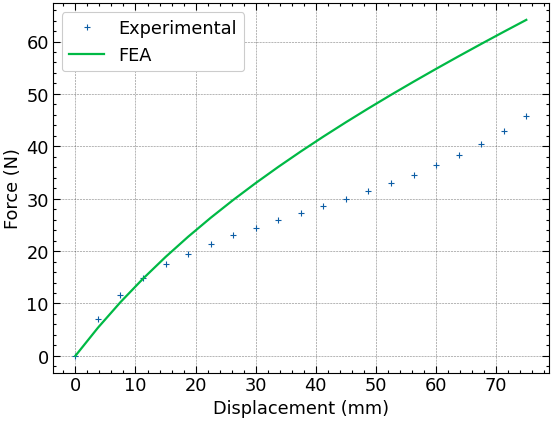

In [12]:
# Plot the experimental and numerical force vs displacement curves
plt.figure()

# Experimental curve
plt.plot(disp_hole_resampled, force_hole_resampled, '+', label="Experimental")

# Numerical curve
plt.plot(disp_hole_resampled, model_force_hole, label="FEA")

plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")

plt.legend()
plt.show()

> **:question: Now perform the inverse identification by using the same principle as previously. You will need to write the residual function, and then use the `least_squares` function to identify the two hyperelastic material constants $ C_1 $ for the rubber part and the ring around the hole.**

*Note: you may need to use bounds for the optimization to ensure that the identified material constant is positive and not too high. I also recommend printing the current value of the material constant during the optimization to check that it is converging.*

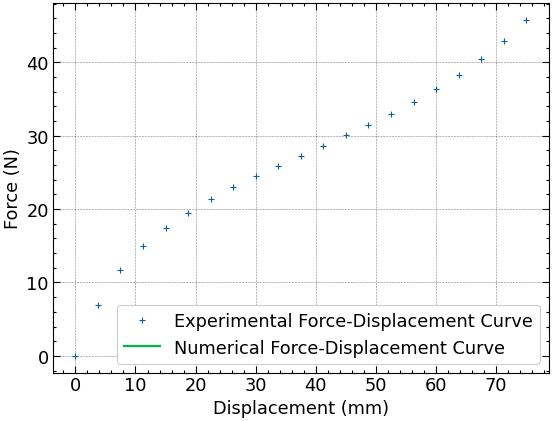

In [13]:
model_force_hole = np.nan * np.ones_like(disp_hole_resampled)

fig = plt.figure()

plt.plot(disp_hole_resampled, force_hole_resampled, '+', label="Experimental Force-Displacement Curve")
num_plot, = plt.plot(disp_hole_resampled, model_force_hole, label="Numerical Force-Displacement Curve")

plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")

plt.legend()

plt.show()


In [14]:
# Define the residual function for the Neo-Hookean model
def residuals_hole(params):
    C1_rubber = params[0]
    C1_ring = params[1]
    model.set_material_parameters_NH(C1_rubber, C1_ring)
    model_force_hole[:] = model.solve(disp_hole_resampled, show_progress=False, update_plot=False)
    print(f"Simulation with C1_rubber = {C1_rubber:.2f} MPa, C1_ring = {C1_ring:.2f} MPa; current residual: {np.linalg.norm(model_force_hole - force_hole_resampled):.2f}")
    num_plot.set_ydata(model_force_hole)
    fig.canvas.draw()
    return model_force_hole - force_hole_resampled

# Initial guess for C1
initial_guess_hole = [1, 1]

# Perform the least squares fitting
bounds = ([1e-3, 1e-3], [100, 100])
xtol = 1e-2 # Stops when the relative error between two consecutive iterates is at most xtol.
result_hole = least_squares(residuals_hole, initial_guess_hole, bounds=bounds, xtol=xtol)

# Extract the fitted C1 values
fitted_C1_rubber = result_hole.x[0]
fitted_C1_ring = result_hole.x[1]
print(f"Fitted C1_rubber: {fitted_C1_rubber:.2f} MPa, Fitted C1_ring: {fitted_C1_ring:.2f} MPa")


Simulation with C1_rubber = 1.00 MPa, C1_ring = 1.00 MPa; current residual: 284.50
Simulation with C1_rubber = 1.00 MPa, C1_ring = 1.00 MPa; current residual: 284.50
Simulation with C1_rubber = 1.00 MPa, C1_ring = 1.00 MPa; current residual: 284.50
Simulation with C1_rubber = 0.59 MPa, C1_ring = 0.59 MPa; current residual: 116.03
Simulation with C1_rubber = 0.59 MPa, C1_ring = 0.59 MPa; current residual: 116.03
Simulation with C1_rubber = 0.59 MPa, C1_ring = 0.59 MPa; current residual: 116.03
Simulation with C1_rubber = 0.40 MPa, C1_ring = 0.41 MPa; current residual: 38.48
Simulation with C1_rubber = 0.40 MPa, C1_ring = 0.41 MPa; current residual: 38.48
Simulation with C1_rubber = 0.40 MPa, C1_ring = 0.41 MPa; current residual: 38.48
Simulation with C1_rubber = 0.33 MPa, C1_ring = 0.33 MPa; current residual: 12.96
Simulation with C1_rubber = 0.33 MPa, C1_ring = 0.33 MPa; current residual: 12.96
Simulation with C1_rubber = 0.33 MPa, C1_ring = 0.33 MPa; current residual: 12.96
Simulation

We now want to check if the strain fields obtained by DIC are consistent with the ones obtained by FEA. Use the code below to visualize both fields.

In [15]:
display(viewer)

Widget(value='<iframe src="http://localhost:45763/index.html?ui=P_0x73f5a4169a00_0&reconnect=auto" class="pyvi…

In [16]:
# Run the simulation once more to get the data for the plots
model.set_material_parameters_NH(fitted_C1_rubber, fitted_C1_ring)
model.solve(disp_hole_resampled)


# Get the experimental data from DIC
axial_strain_DIC = utils.read_mat_data("Test Data/Hole/DIC Data/Data/hole_rubber_last.mat", "exx")

# Plot the strain field in the undeformed configuration
axial_strain_FE = model.get_strain_field_on_undeformed_mesh()
viewer = utils.plot_fields_side_by_side(axial_strain_DIC, axial_strain_FE)

display(viewer)

Increment 0: Displacement: 0.00 mm, Force: -0.00 N
Increment 1: Displacement: 3.75 mm, Force: 3.89 N
Increment 2: Displacement: 7.50 mm, Force: 7.39 N
Increment 3: Displacement: 11.25 mm, Force: 10.55 N
Increment 4: Displacement: 15.00 mm, Force: 13.45 N
Increment 5: Displacement: 18.75 mm, Force: 16.13 N
Increment 6: Displacement: 22.50 mm, Force: 18.62 N
Increment 7: Displacement: 26.25 mm, Force: 20.96 N
Increment 8: Displacement: 30.00 mm, Force: 23.17 N
Increment 9: Displacement: 33.75 mm, Force: 25.28 N
Increment 10: Displacement: 37.50 mm, Force: 27.29 N
Increment 11: Displacement: 41.25 mm, Force: 29.23 N
Increment 12: Displacement: 45.00 mm, Force: 31.10 N
Increment 13: Displacement: 48.75 mm, Force: 32.92 N
Increment 14: Displacement: 52.50 mm, Force: 34.68 N
Increment 15: Displacement: 56.25 mm, Force: 36.41 N
Increment 16: Displacement: 60.00 mm, Force: 38.10 N
Increment 17: Displacement: 63.75 mm, Force: 39.75 N
Increment 18: Displacement: 67.50 mm, Force: 41.38 N
Incremen

Widget(value='<iframe src="http://localhost:45763/index.html?ui=P_0x73f583f838f0_1&reconnect=auto" class="pyvi…

> **:question: Comment on the consistency between the DIC and FEA strain fields. Why do you think they are not perfectly aligned? How could we improve the results?**